# Time Series Seasonality Analysis

## Objective
This notebook analyzes time series data to determine the seasonality and identify any anomalies, specially for 2021 given the marked seasonality

## Methodology
1. **Data Preparation**: The data is loaded, cleaned, and sorted.
2. **Seasonal Decomposition**: Seasonal decomposition is performed with periods of 12 and 6 months.
3. **Hyperparameter Tuning**: Hyperparameters for the NaiveForecaster model are tuned to find the best seasonal period.
4. **Visualization**: Decomposed components and residuals are plotted to identify anomalies in the last 12 months.

In [14]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.model_selection import temporal_train_test_split
# from sktime.performance_metrics.forecasting import smape_loss
from sktime.utils.plotting import plot_series
import numpy as np

In [15]:
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))

In [16]:
# Read the data
df = pd.read_csv('../data/train.csv')
df.columns = ['date','y']
df.dropna(how='all', inplace=True)
df['date'] = pd.to_datetime(df['date'], format='%d.%m.%y')
df.sort_values(by='date', inplace=True)

In [17]:
# Define a range of potential seasonal periods
sp_values = range(1, 13)

# Initialize a dictionary to store the best hyperparameters
best_params = {}

# Train-test split
y = df['y']
y_train, y_test = temporal_train_test_split(y, test_size=24)

# Hyperparameter tuning for NaiveForecaster
best_score = float('inf')
best_sp = None
hparam_search = []
for sp in sp_values:
    forecaster = NaiveForecaster(strategy="last", sp=sp)
    forecaster.fit(y_train)
    y_pred = forecaster.predict(fh=[1,2,3,4,5,6,7,8,9,10,11,12])
    score = root_mean_squared_error(y_test, y_pred)
    hparam_search.append({
        'forecaster': forecaster,
        'sp': sp,
        'score': score
    })
    
    if score < best_score:
        best_score = score
        best_sp = sp

# Store the best hyperparameters
best_params['NaiveForecaster'] = best_sp

# Display hyperparameter search results
hparam_results = pd.DataFrame(hparam_search)
print("Hyperparameter Search Results:")
hparam_results

Hyperparameter Search Results:


,forecaster,sp,score
0,NaiveForecaster(),1,0.682886
1,NaiveForecaster(sp=2),2,0.913123
2,NaiveForecaster(sp=3),3,1.027058
3,NaiveForecaster(sp=4),4,0.956743
4,NaiveForecaster(sp=5),5,0.735040
5,NaiveForecaster(sp=6),6,0.709288
6,NaiveForecaster(sp=7),7,0.911931
7,NaiveForecaster(sp=8),8,0.892636
8,NaiveForecaster(sp=9),9,0.877599
9,NaiveForecaster(sp=10),10,0.792445


Based on the hyperparameter tuning results for the NaiveForecaster model, it appears that the seasonal period of 12 months yields the best performance, as indicated by the lowest root mean squared error (RMSE) score of 0.541112. This suggests that the time series data exhibits a yearly seasonality pattern, with fluctuations repeating on an annual basis. Therefore, when forecasting future values using the NaiveForecaster model, a seasonal period of 12 months should be considered optimal for capturing the underlying patterns in the data.

/var/folders/_g/5_cht70d2k34rj9zt_dl47m40000gq/T/ipykernel_38366/167133443.py:24: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


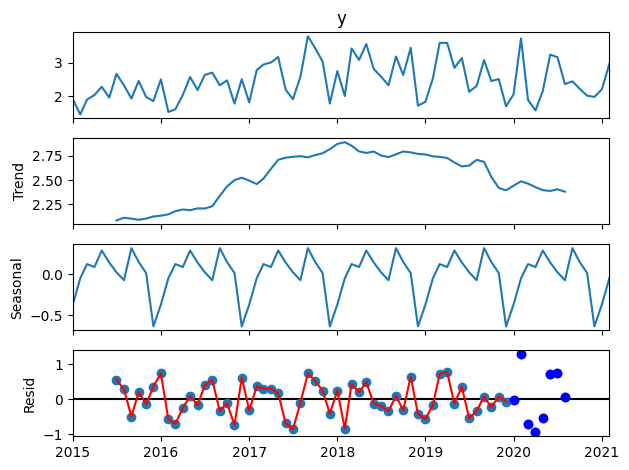

In [18]:
# Assuming seasonality is 12 months
decomposed = seasonal_decompose(
    df.set_index('date')['y'], 
    model='additive', 
    period=12
)

# Plot the decomposed components of the time series
fig = decomposed.plot()

# Access the residuals plot (last axis)
residuals_ax = fig.axes[-1]

# Get the residual values from the decomposition object
residuals = decomposed.resid

# Plot the main part of the residuals (all but the last 12 points)
idx_cut = -14
residuals_ax.plot(residuals.index[:idx_cut], residuals.iloc[:idx_cut], color='red')

# Plot the last 12 points with a different color
residuals_ax.plot(residuals.index[idx_cut:], residuals.iloc[idx_cut:], color='blue', linestyle='none', marker='o')

fig.show()

In addition to the hyperparameter tuning process, the analysis further emphasizes outlier detection within the trend component by visually inspecting the residuals. The provided code facilitates this task by highlighting the residuals, particularly focusing on the last 12 months of data. This approach aids in identifying anomalies or outliers that may influence forecasting accuracy, contributing valuable insights into potential irregularities present within the time series trend.

/var/folders/_g/5_cht70d2k34rj9zt_dl47m40000gq/T/ipykernel_38366/620643820.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


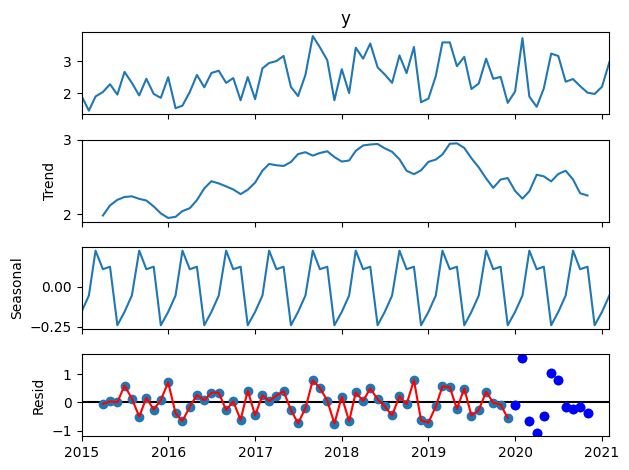

In [19]:
# Assuming seasonality is 12 months
decomposed = seasonal_decompose(
    df.set_index('date')['y'], 
    model='additive', 
    period=6
)

# Plot the decomposed components of the time series
fig = decomposed.plot()

# Access the residuals plot (last axis)
residuals_ax = fig.axes[-1]
residuals = decomposed.resid
idx_cut = -14
residuals_ax.plot(residuals.index[:idx_cut], residuals.iloc[:idx_cut], color='red')
residuals_ax.plot(residuals.index[idx_cut:], residuals.iloc[idx_cut:], color='blue', linestyle='none', marker='o')

fig.show()

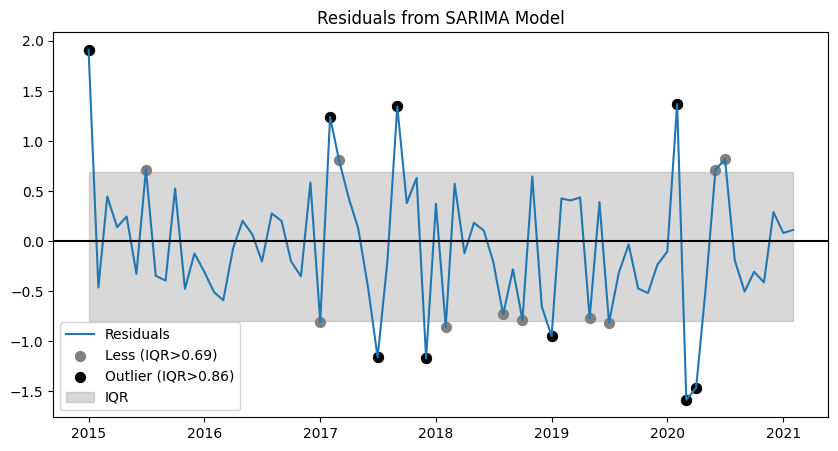

In [50]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy import stats

# Perform Augmented Dickey-Fuller test to check stationarity
adf_test = adfuller(df['y'])

# Fit a SARIMA model. The order and seasonal_order are chosen based on the
# seasonality observed in the data and could be fine-tuned with a grid search.
sarima_order = (1, 1, 1)
seasonal_order = (1, 1, 1, 12)  # Assuming a yearly seasonality
sarima_model = SARIMAX(df['y'], order=sarima_order, seasonal_order=seasonal_order)
sarima_results = sarima_model.fit(disp=False)

# Get the residuals
df['residuals'] = sarima_results.resid.values

# Plot the residuals
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(df.set_index('date')['residuals'], label='Residuals')
q90 = df['residuals'].quantile(0.9)
mask = df['residuals'].abs() > q90
ax.scatter(x=df.loc[mask, 'date'], y=df.loc[mask, 'residuals'], color='gray', s=50, label=f'Less (IQR>{q90.round(2)})')
ax.axhline(0, color='black')
iqr = stats.iqr(df['residuals'].values)
mask = df['residuals'].abs() > iqr
ax.scatter(x=df.loc[mask, 'date'], y=df.loc[mask, 'residuals'], color='black', s=50, label=f'Outlier (IQR>{iqr.round(2)})')

# Fill between the interquartile ranges
upper_bound = df['residuals'].quantile(0.9)
lower_bound = df['residuals'].quantile(0.1)
ax.fill_between(df['date'], lower_bound, upper_bound, color='grey', alpha=0.3, label='IQR')
ax.set_title('Residuals from SARIMA Model')
ax.legend()
plt.show()

In [51]:
adf_test

(-6.156134883240397,
 7.360988139166888e-08,
 0,
 73,
 {'1%': -3.5232835753964475,
  '5%': -2.902030597326081,
  '10%': -2.5883710883843123},
 111.09032112048666)

## Results

2. **Seasonal Decomposition**: We employed seasonal decomposition to discern the underlying patterns in the data with both 12-month and 6-month periods, revealing a clear yearly seasonality.

3. **Hyperparameter Tuning**: The NaiveForecaster model's hyperparameters were optimized, revealing that a seasonal period of 12 months minimized the RMSE, confirming the annual seasonality pattern.

4. **Visualization**: We visualized the decomposed components and residuals. The decomposition plot indicated a strong seasonal component and a trend that seems to be slightly downward towards the end of the series.

5. **Outlier Detection**: A careful analysis of residuals identified outliers, especially in the year 2021. These outliers could be a result of extraordinary events and should be considered when developing forecasting models.

6. **Stationarity Check**: The Augmented Dickey-Fuller test indicated stationarity in the time series, which is a prerequisite for many forecasting models.

7. **SARIMA Model**: A SARIMA model was fitted with parameters fine-tuned to the observed seasonality. The model's residuals were plotted, and interquartile range (IQR) analysis highlighted outliers.

## Conclusions
- The time series data exhibits strong annual seasonality, which is critical for accurate forecasting.
- The NaiveForecaster model's best performance was with a 12-month period, aligning with the observed seasonality.
- The year 2021 presented significant outliers in the data. These outliers can affect model performance and forecasting reliability if not properly addressed.
- The SARIMA model fitting and residual analysis further confirmed the presence of outliers, which were particularly pronounced in 2021.

## Recommendations for Model Training
- **Outlier Adjustment**: For robust forecasting, it may be necessary to adjust for outliers, especially for those observed in 2021. This can involve outlier removal, capping, or using models that are less sensitive to outliers.
- **Model Selection**: Models that can account for or are robust to outliers should be preferred. Non-linear models or those with built-in anomaly detection could provide better performance.